In [6]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()


## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}_ahead{}".format(name,i), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat)))
    

In [3]:
train = pd.read_csv("train_nocat_s.csv")
test = pd.read_csv("test_nocat_s.csv")

In [4]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

### Seeking outliers

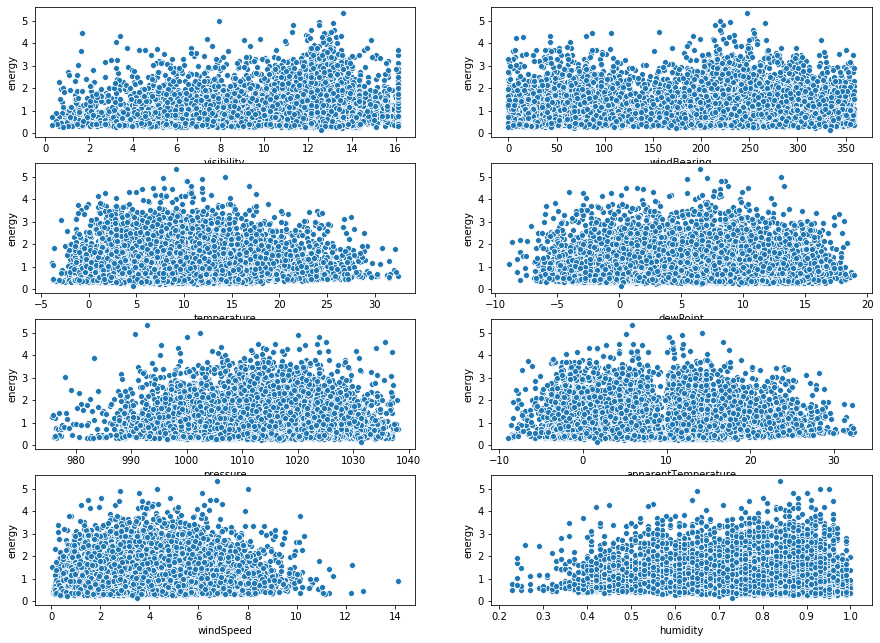

In [7]:
scatter_plot(train)

In [8]:
## deal with the only outliers in  energy data 
train.drop(train[(train["energy"] > 20)].index, inplace = True)
train.reset_index(drop=True, inplace=True)

### Calibration of distribution

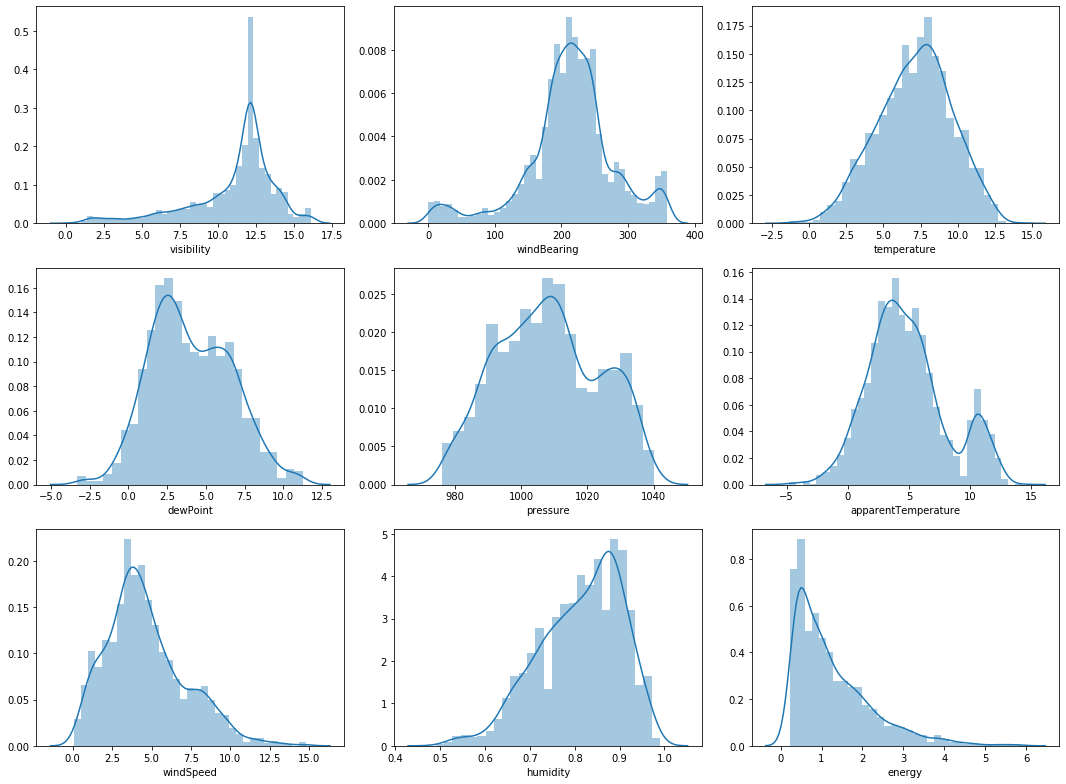

In [9]:
distri_plot(test)


We can observe that 
- left skew: **visibility**, **humidty** 
- right skew:  **windSpeed**, **temperature**
- weird shape: **windBearing**, **dewPoint**, **apparetTemp**

Apply transformation on them for more normal distribution

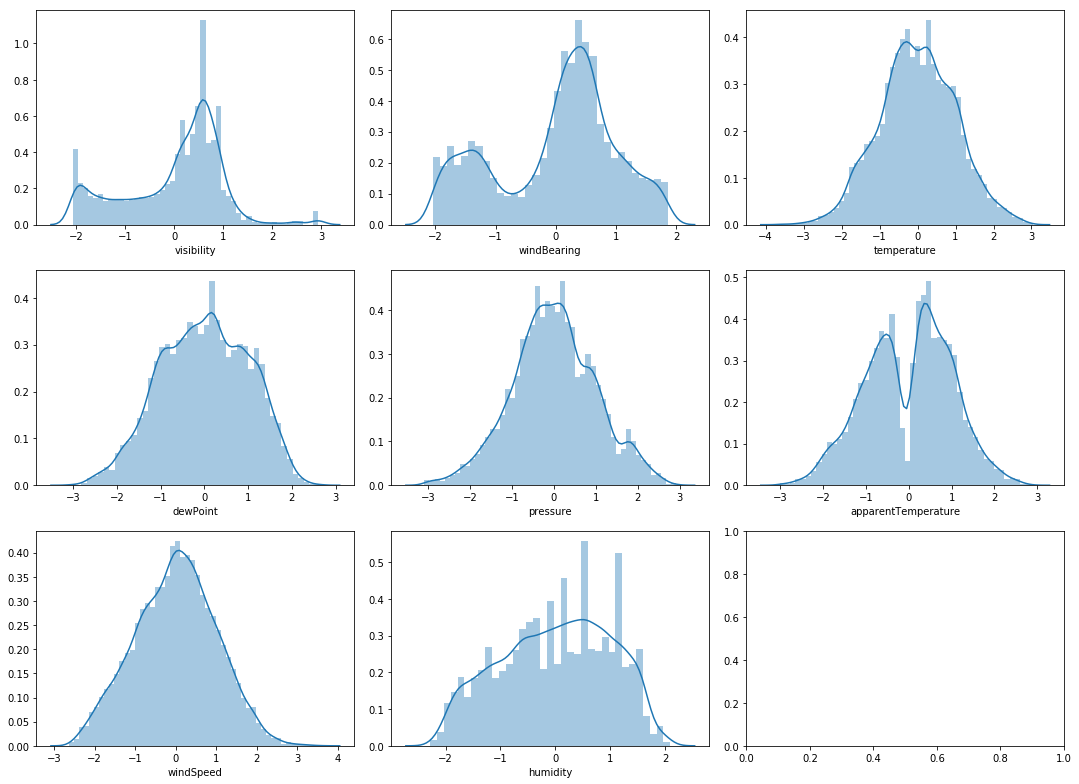

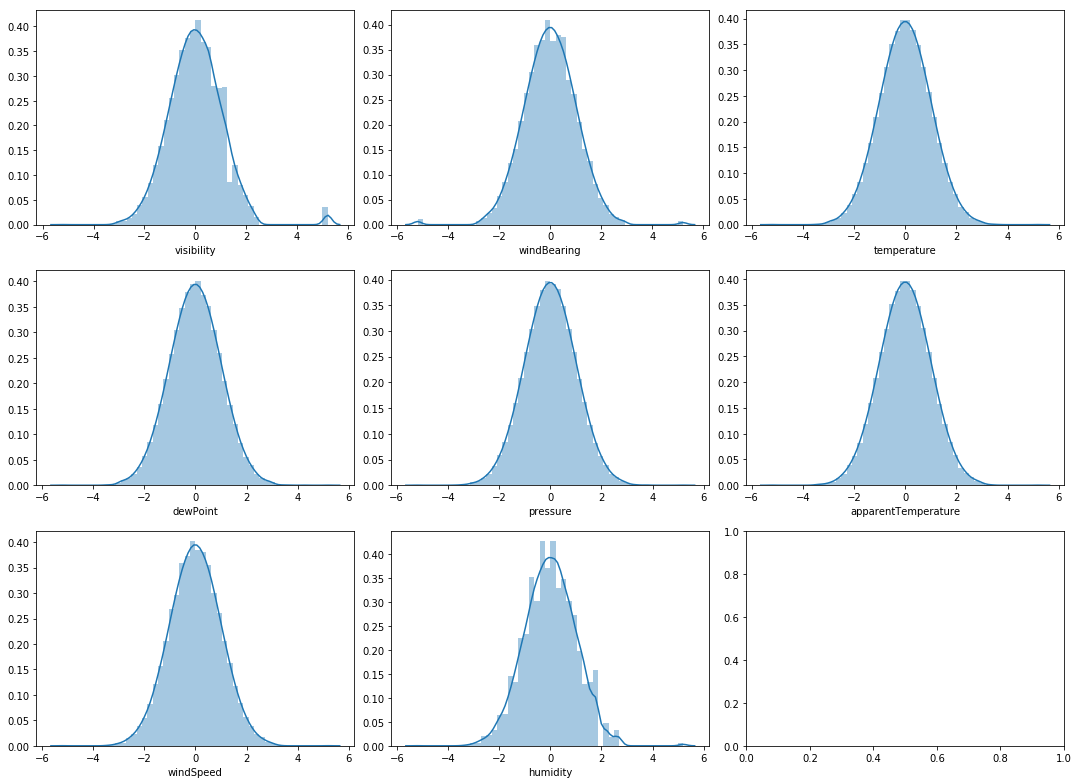

In [294]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
    
def power_trans(df):
    pt_boxc = PowerTransformer(method = "yeo-johnson")
    df_slice = df.iloc[:,:8]
    pt.fit(df_slice)
    df_trans = pd.DataFrame(pt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans
train_trans = power_trans(train)

def quantile_trans(df):
    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
    df_slice = df.iloc[:,:8]
    qt.fit(df_slice)
    df_trans = pd.DataFrame(qt.transform(df_slice), columns=['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'])
    return df_trans

train_trans = power_trans(train)
train_quantile = quantile_trans(train)

##plot distribution
distri_plot(train_trans)
distri_plot(train_quantile)

### Creat lag ahead scenarios

In [10]:
#create 48 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
single_w = train.iloc[:13991,:8]
#create 48 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_w.shape, ahead_e.shape, single_w.shape

((9951, 392), (9951, 49), (9999, 8))

### Scaling 

In [54]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(ahead_w)
mt = mmscaler.transform(ahead_w)


### Feature Selection

In [12]:
# Tree based feature selection
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(random_state=0).fit(mt, ahead_e)
model = SelectFromModel(reg, prefit=True)
cols = model.get_support(indices=True)
mt_feature = model.transform(mt)
cols ## the selected features column

array([  6,   9,  11,  26,  42,  43,  52,  67,  84,  86,  95, 100, 105,
       107, 109, 124, 126, 135, 143, 145, 146, 156, 202, 251, 259, 263,
       277, 278, 289, 293, 296, 299, 311, 312, 314, 315, 317, 322, 327,
       328, 332, 336, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
       353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
       366, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379,
       380, 381, 382, 383, 384, 385, 386, 388, 389, 390, 391])



### Random Forest Regression: Manual ML

In [26]:
from sklearn.ensemble import RandomForestRegressor

X = mt_feature
y = ahead_e

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

#for i in range(50):
rfr = RandomForestRegressor(max_depth=15, random_state=1, n_estimators=100)
rfr.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [27]:
yhat = rfr.predict(val_X)

### Result evaluation: validation set

In [28]:
get_eval(val_y, yhat)

MSE: 0.31578032801108735
MAE: 0.40654095249515154
r2_score: 0.39235520361291126


**Visualization**

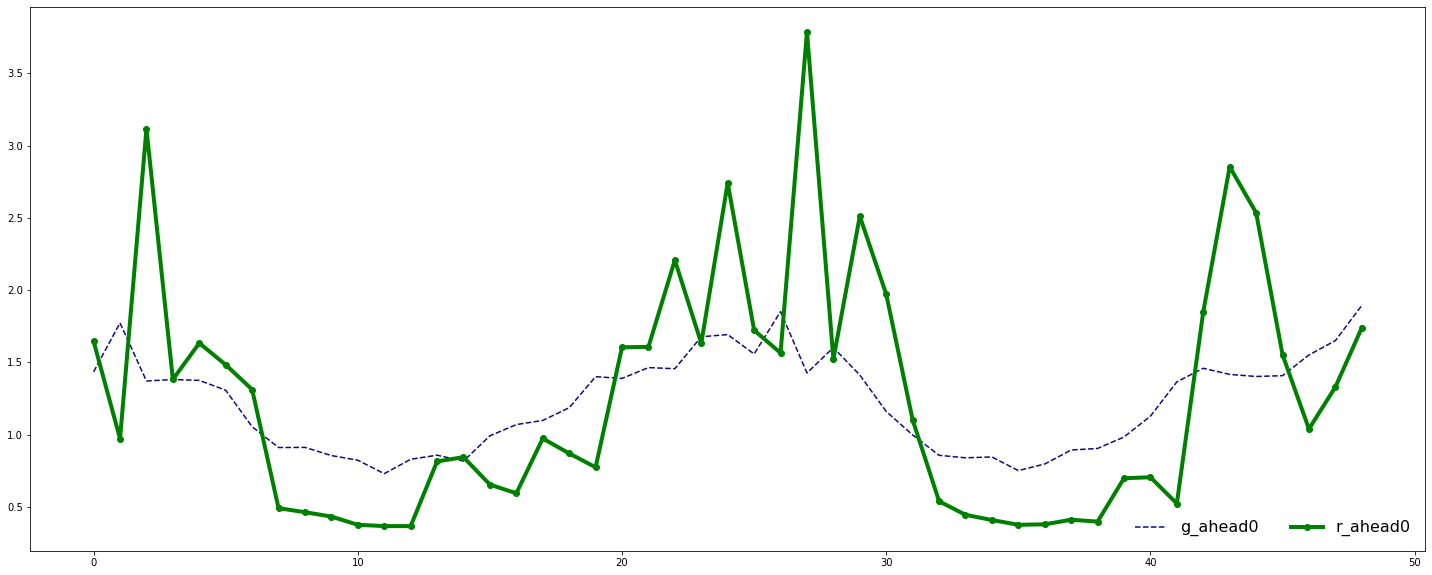

In [29]:
## assignment
real = val_y.to_numpy()
guess = yhat
real = real[:1,:49]
guess = guess[:1,:49]
rpdf = plot_df(real, "r")
gpdf = plot_df(guess, "g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})

plt.show()

### Result evaluation: test set

**Data preparation for test set**

- prepare recency features
- feature scaling 
- identify feature picked from previous training process

In [30]:
## create 48 hours recency effect matrix
ahead_wt = lag_ahead_series(test.iloc[:,:8], n_in=0, n_out=49, n_vars = 8, dropnan=True)
#single_wt = train.iloc[:5775,:8]
#create 48 housrs ahead energy consumption matrix
ahead_et = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=49, n_vars = 1, dropnan=True)

ahead_wt.shape, ahead_et.shape

((2468, 392), (2468, 49))

In [55]:
## feature scaling
#single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
mtest = mmscaler.transform(ahead_wt)

In [56]:
## feature pick up
test_x = mtest[:,cols]
test_y = ahead_et

In [33]:
## Prediction with test data
yt_hat = rfr.predict(test_x)

**Result Evaluation**

In [34]:
get_eval(test_y, yt_hat)

MSE: 0.6967690574931352
MAE: 0.5760130347131315
r2_score: 0.22286850453457754


**Visualization**

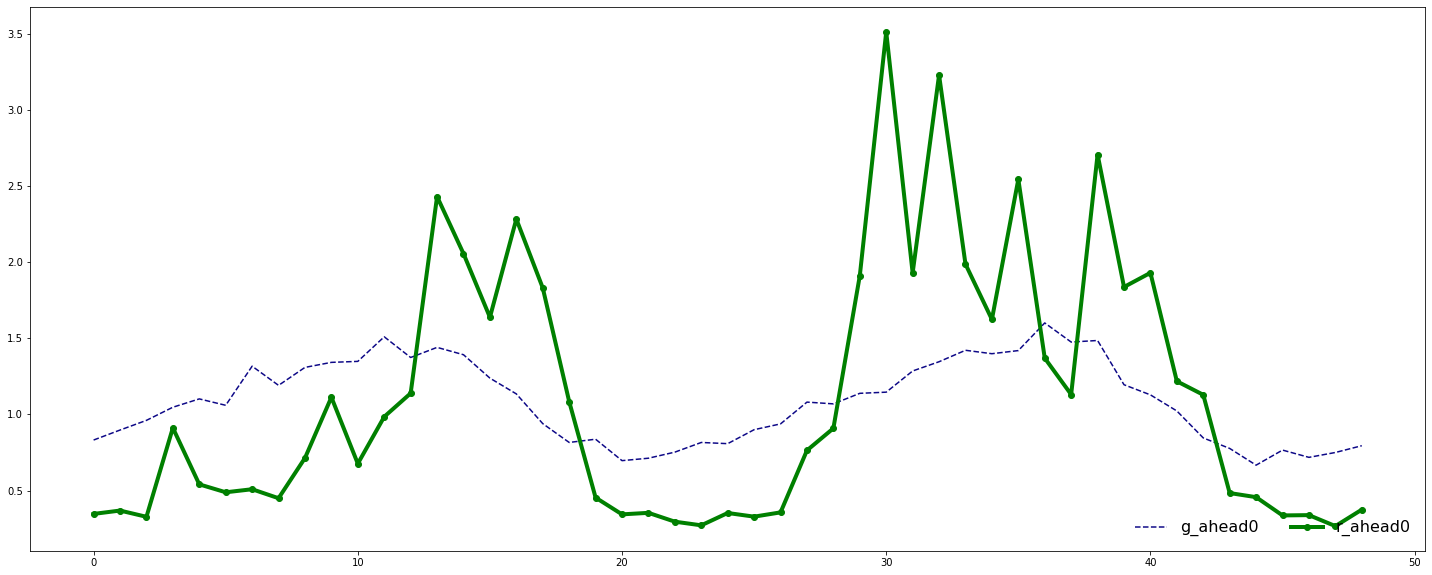

In [35]:
real = test_y.to_numpy()
guess = yt_hat
real = real[0:1,:49]
guess = guess[0:1,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Xgboost: Manual

In [19]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

X = mt_feature
y = ahead_e
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 8)
#mr = MultiOutputRegressor(xgbr, n_jobs = 4)
#mr.fit(train_X, train_y)
rc = RegressorChain(xgbr, cv = 5, random_state = 123)
rc.fit(train_X, train_y)

[13:51:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[14:03:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[14:18:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:18:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:19:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[14:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[14:52:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RegressorChain(base_estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           importance_type='gain',
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=10, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, njobs=8, nthread=None,
                                           objective='reg:linear',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=

### Result evaluation: validation set

In [48]:
yhat = mr.predict(val_X)

In [49]:
get_eval(val_y, yhat)

MSE: 0.1027901654342744
MAE: 0.1677590063487328
r2_score: 0.802190660458604


**Visualization**

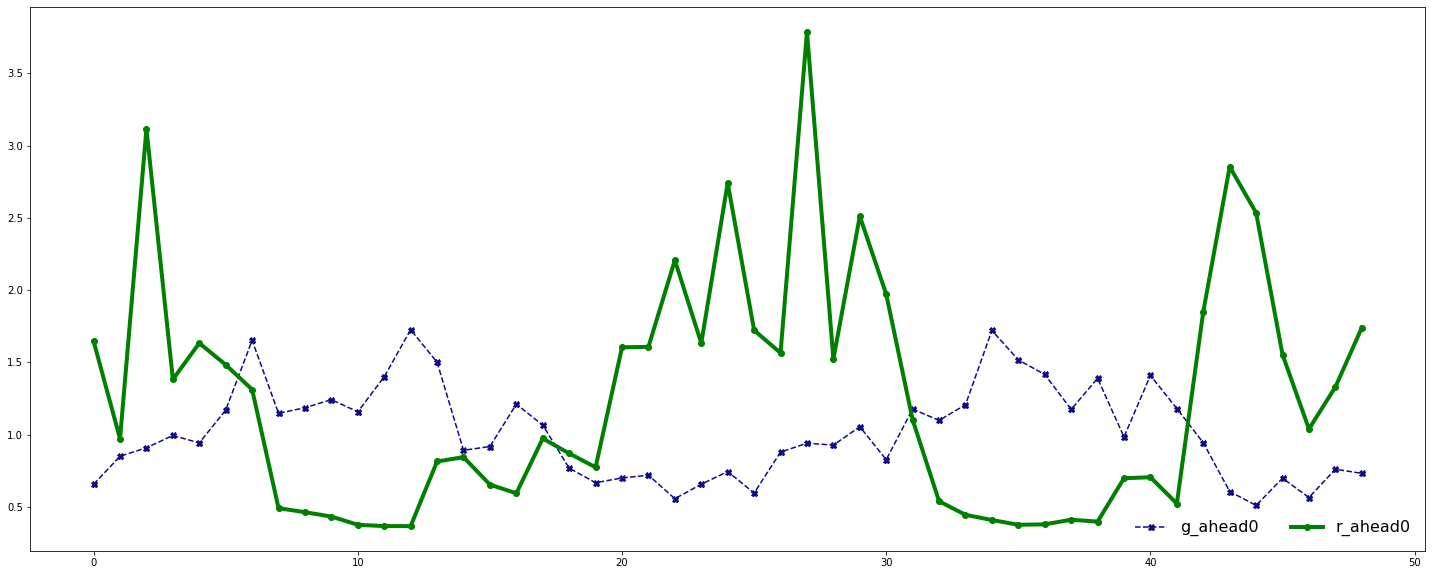

In [65]:
real = val_y.to_numpy()
guess = yhat
real = real[0:1,:49]
guess = guess[0:1,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Result evaluation: test set

In [66]:
yhat = mr.predict(test_x)

In [67]:
get_eval(test_y, yhat)

MSE: 0.7318120917947062
MAE: 0.580695760541123
r2_score: 0.18378537862342778


**Visualization**


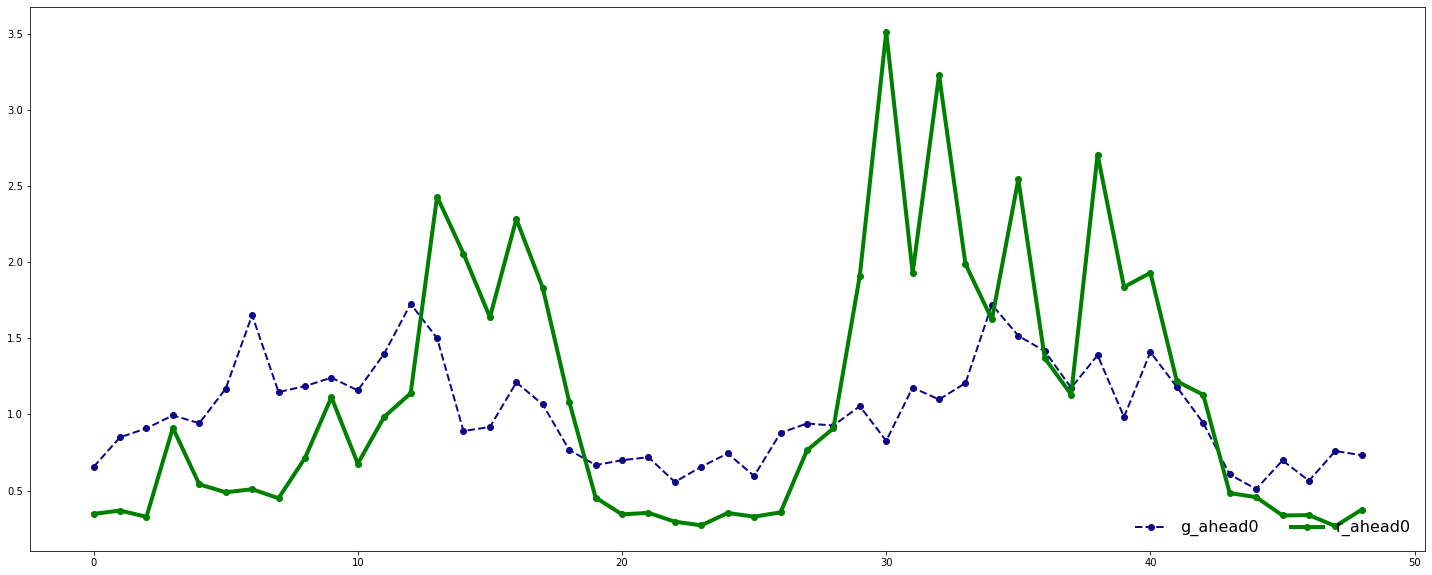

In [69]:
real = test_y.to_numpy()
guess = yhat
real = real[:1,:49]
guess = guess[:1,:49]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--o',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 50)             88600     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 49)             2499      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 10)             500       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1, 49)             539       
Total params: 92,138
Trainable params: 92,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 2s - loss: 60.3109
Epoch 2/50
 - 1s - loss: 43.7603
Epoch 3/50
 - 1s - loss: 41.9805
Epoch 4/50
 - 1s - loss: 40.2321
Epoch 5/50
 - 1s - loss: 39.0950
Epoch 6/50
 - 1s - loss: 38.5087
Epoch 7/50
 - 1s - loss: 38.1689
Epoch 8/50
 - 1s 

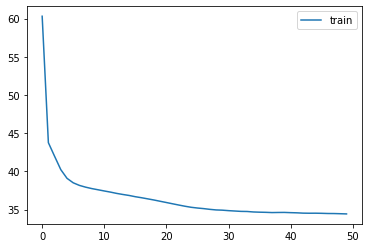

In [35]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(mt, ahead_e, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.values.reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.add(TimeDistributed(Dense(10)))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='mape', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [26]:
yhat = model.predict(lval_X)
yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])

**performace**


In [29]:
get_eval(val_y, yhat)

MSE: 0.49182851669521105
MAE: 0.44126855651488345
r2_score: 0.052498034387342386


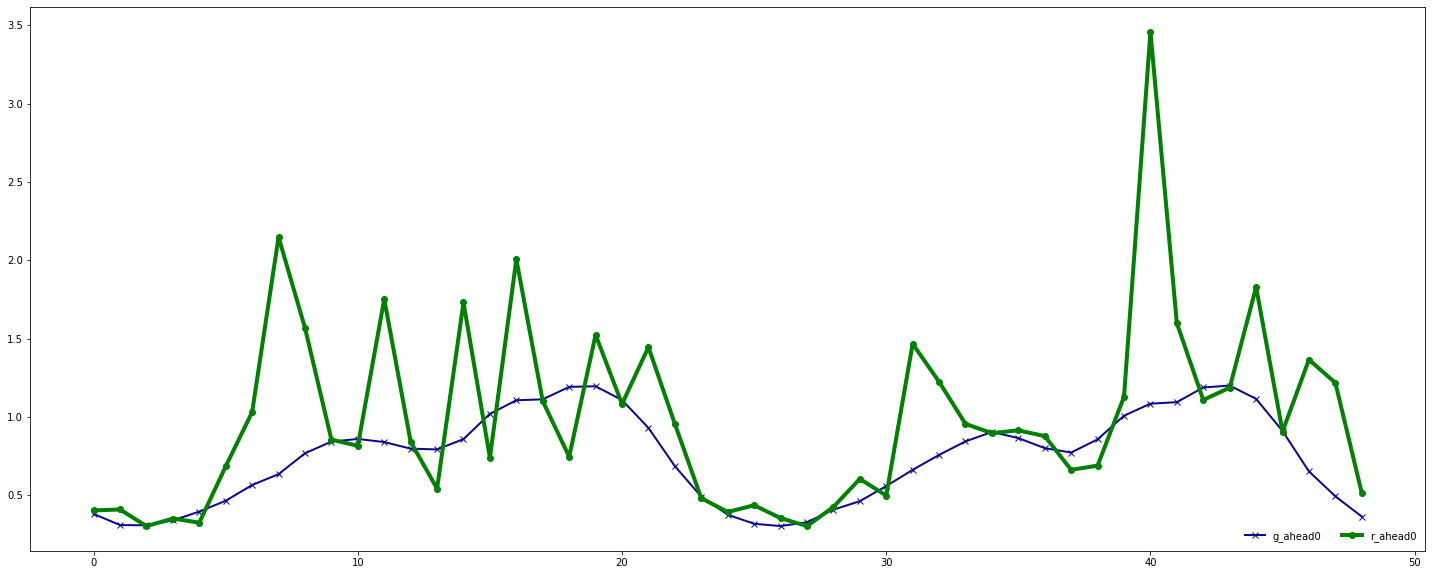

In [34]:
real = val_y.to_numpy()
guess = yhat

real = real[:1,:]
guess = guess[:1,:]

rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
ax = plt.gca()

    
#plot 
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()